In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import os.path as osp
import pandas as pd
sys.path.insert(1, osp.abspath('../'))

## BoundingBoxDataset example

In [29]:
from modules.torch_dataset.bounding_box_dataset import BoundingBoxDataset

det_df = pd.read_csv("/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/annotations/S01/c001/gt.txt")
ds = BoundingBoxDataset(det_df, 
                        frame_dir="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/frames/S01/c001",
                        frame_width=1080, 
                        frame_height=1920, 
                        output_size=(224, 224),
                        fully_qualified_dir=True,
                        pad_=False,
                        return_det_ids_and_frame=True,
                        mode='train',
                        augmentation=None)

In [30]:
from torch.utils.data import DataLoader  
bb_loader = DataLoader(ds, 
                        batch_size=32, 
                        pin_memory=True, 
                        num_workers=2)

In [31]:
frame_num, det_id, camera, sequence, bboxes = ds[0]

In [32]:
bboxes.permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


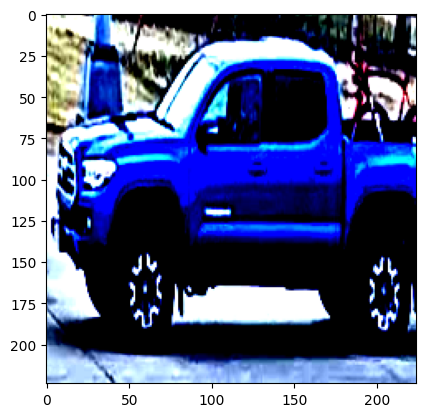

In [33]:
import matplotlib.pyplot as plt
plt.imshow(bboxes.permute(1,2,0))

## SequenceGraphDataset example

In [ ]:
from modules.torch_dataset.sequence_graph_dataset import SequenceGraphDataset

dataset = SequenceGraphDataset(sequence_path_prefix='datasets/AIC20', 
                               sequence_names=['S01', 'S03', 'S04'], 
                                annotations_filename='gt.txt')

data = dataset[0]     # Access the first processed graph

In [5]:
import pandas as pd
edge = pd.read_json("datasets/AIC20/logs/S03/sequence_graph_edges.json")
edge.head()

,src_node_id,dst_node_id,src_obj_id,dst_obj_id,edge_labels
0,0,14,252,252,1
1,0,15,252,242,0
2,0,16,252,256,0
3,0,17,252,246,0
4,0,18,252,247,0


In [37]:
edge[(edge.src_obj_id == edge.dst_obj_id)].head()

,src_node_id,dst_node_id,src_obj_id,dst_obj_id,edge_labels
0,0,14,252,252,1
17,0,31,252,252,1
31,0,45,252,252,1
48,0,62,252,252,1
67,1,15,242,242,1


## ObjectGraphDataset example

In [4]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="/Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cpu")

Loading pretrained model from /Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [5]:
import torchvision.transforms.v2 as transforms
augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(scale=(0.02, 0.15)),
        transforms.RandomRotation(degrees=0.15),
        transforms.RandomPerspective(distortion_scale=0.25)
    ])

In [216]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np

data_df = AnnotationsProcessor(sequence_path='/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20', annotations_filename='gt.txt').consolidate_annotations(['S02'], ["frame", "camera"])
ids = np.random.choice(data_df.id.unique(), 20)
data_df = data_df[data_df.id.isin(ids)]

dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=48, 
                             resized_img_shape=(224, 224), 
                             orignal_img_shape=(1920, 1080), 
                             augmentation=None,
                             return_dataframes=False)

Sampling object ids


In [217]:
data = dataset[0]

Computing embeddings


100%|██████████| 52/52 [07:54<00:00,  9.13s/it]

Generating nodes
Generating edges
Creating PyG graph


In [223]:
data.y

tensor([ 97, 107, 127, 138, 144, 151, 158, 172, 185, 189, 213, 222, 223, 237,
         97, 107, 138, 147, 158, 172, 185, 186, 213, 222, 237, 127, 138, 144,
        147, 151, 172, 173, 185, 189, 223, 237,  97, 107, 127, 144, 147, 151,
        158, 172, 173, 185, 186, 189, 213, 223, 237])

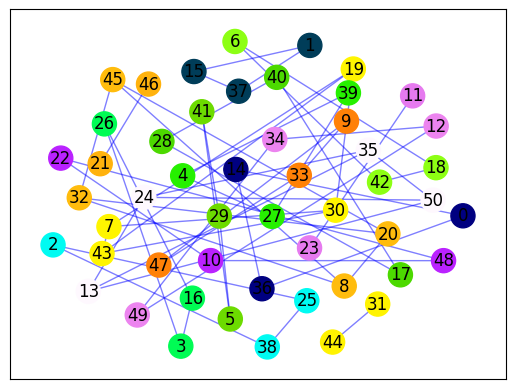

In [231]:
from torch_geometric.utils.convert import to_networkx, from_networkx
from modules.torch_dataset.utils import draw_pyg_network
import networkx as nx
draw_pyg_network(data, [1], layout='spring')

## ObjectGraphDataset with negative sampling

In [93]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="/Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cpu")

Loading pretrained model from /Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [116]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np


dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", 
                             sequence_names=['S02'], 
                             annotations_filename='gt.txt', 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=48, 
                             resized_img_shape=(224, 224), 
                             orignal_img_shape=(1920, 1080), 
                             negative_sampling=True,
                             augmentation=None,
                             return_dataframes=False)

Sampling object ids


In [117]:
data = dataset[0] 

Computing embeddings


100%|██████████| 55/55 [09:18<00:00, 10.15s/it]

Generating nodes
Generating edges
Creating PyG graph


In [213]:
from modules.torch_dataset.utils import draw_pyg_network

draw_pyg_network(data, [ 1])

AttributeError: 'tuple' object has no attribute 'edge_index'

## Testing post-processing

In [232]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np

data_df = AnnotationsProcessor(sequence_path='/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20', annotations_filename='gt.txt').consolidate_annotations(['S02'], ["frame", "camera"])

# Loading ground truth files
gt_df = pd.read_csv("/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/ground_truth_S02.txt", 
                    sep=' ', 
                    names=['camera','id', 'frame', 'xmin', 'ymin', 'width', 'height', 'xworld', 'yworld'])

#ids = np.random.choice(data_df.id.unique(), 30)
#data_df = data_df[data_df.id.isin(ids)]
#gt_df = gt_df[gt_df.id.isin(ids)]



In [233]:
gt_df = data_df.copy() 

In [234]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="/Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cpu")

Loading pretrained model from /Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [235]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np
import torch_geometric.transforms as T

dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=300, 
                             resized_img_shape=(224, 224), 
                             orignal_img_shape=(1920, 1080), 
                             negative_sampling=False,
                             augmentation=None,
                             return_dataframes=True,
                             graph_transform=T.ToUndirected())
data = dataset[0] 

Sampling object ids
Computing embeddings


100%|██████████| 70/70 [1:01:59<00:00, 53.14s/it]


Generating nodes
Generating edges
Creating PyG graph


In [51]:
data_df.camera.unique()

array(['c008', 'c006', 'c007', 'c009'], dtype=object)

In [236]:
import yaml
with open("/Users/hectormejia/Documents/TFM/mcmt_gnn/config/training_rgcnn.yml", "r") as config_file:
    config = yaml.safe_load(config_file)
    gnn_arch = config["gnn_arch"]

In [34]:
model_state

NameError: name 'model_state' is not defined

In [237]:
import torch
from models.mcmt.rgnn import MOTMPNet
model_state = torch.load("/Users/hectormejia/Documents/TFM/mcmt_gnn/results/checkpoints/latest.pth.tar", map_location=torch.device('cpu'))

model = MOTMPNet(gnn_arch)
model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [189]:
data_df['id_old'] = data_df.id

In [212]:
grouped = node_df.groupby(["camera", "object_id"]).count()
grouped

node_id  sequence_name
camera object_id                        
c006   96               1              1
       97               1              1
       98               1              1
       99               1              1
       100              1              1
...                   ...            ...
c009   236              1              1
       237              1              1
       238              1              1
       239              1              1
       240              1              1

[450 rows x 2 columns]

In [239]:
# Batches from our custom datasets return these vars
graph, node_df, edge_df, sampled_df = data

with torch.no_grad():
    # Output predictions from GNN            
    output_dict, _ = model(graph)
    logits = output_dict['classified_edges'][0]
    preds_prob = F.softmax(logits, dim=1).cpu()
    predictions = torch.argmax(logits, dim=1).cpu()

In [240]:
(predictions == graph.edge_labels).sum() / len(predictions)

tensor(0.9478)

In [244]:
from sklearn.metrics import classification_report
print(classification_report(graph.edge_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    149456
           1       0.10      0.82      0.17       998

    accuracy                           0.95    150454
   macro avg       0.55      0.89      0.57    150454
weighted avg       0.99      0.95      0.97    150454



In [196]:
import torch
from modules.inference.postprocessing import postprocessing, filter_dets_outside_frame_bounds, remove_non_roi
import torch.nn.functional as F

# Batches from our custom datasets return these vars
graph, node_df, _, _ = data

with torch.no_grad():
    # Output predictions from GNN            
    output_dict, _ = model(graph)
    logits = output_dict['classified_edges'][0]
    preds_prob = F.softmax(logits, dim=1).cpu()
    predictions = torch.argmax(logits, dim=1).cpu()

# Connected components output
id_pred, predictions = postprocessing(4, 
                                    preds_prob,
                                    predictions,
                                    graph.edge_index.cpu().numpy(),
                                    graph.cpu(),
                                    True, False)

# Generate tracking dataframe
for n in range(len(graph.x)):
    id_new = int(id_pred[n])
    cam_id = node_df.camera[n]
    id_old = node_df.object_id[n]

    # Assign the labels from the connected components to the detections df
    data_df.loc[(data_df['id'] == id_old) & 
                    (data_df['camera'] == cam_id),'id'] = id_new

# If required, remove detections that go beyond the frame limits

#data_df = filter_dets_outside_frame_bounds(data_df, 1920, 1080)

#data_df = remove_non_roi("/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", data_df)

/Users/hectormejia/Documents/TFM/mcmt_gnn/modules/inference/postprocessing.py:345: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return id_pred, torch.tensor(whole_edges_prediction)


In [197]:
import motmetrics as mm
from modules.inference.postprocessing import fix_annotation_frames
data_df.camera = data_df.camera.apply(lambda cam: int(cam.replace('c', '')))
gt_df.camera = gt_df.camera.apply(lambda cam: int(cam.replace('c', '')))

gt_df, pred_df = fix_annotation_frames(gt_df, data_df)

# Setting column names as motmetrics requires it
gt_df = gt_df.rename(columns={'frame': 'FrameId',
                            'xmin': 'X', 
                            'ymin': 'Y', 
                            'width': 'Width', 
                            'height': 'Height',
                            'id': 'Id'})

pred_df = pred_df.rename(columns={'frame': 'FrameId',
                            'xmin': 'X', 
                            'ymin': 'Y', 
                            'width': 'Width', 
                            'height': 'Height',
                            'id': 'Id'})

# Setting frame id and id as index since motmetrics requires it
gt_df = gt_df.set_index(['FrameId', 'Id'])
pred_df = pred_df.set_index(['FrameId', 'Id'])

# Compute metrics using Pymotmetrics
mh = mm.metrics.create()
accumulator = mm.utils.compare_to_groundtruth(gt_df, pred_df, 'iou', distth=0.6)
metrics=[*mm.metrics.motchallenge_metrics, *['num_frames','idfp','idfn','idtp']]
summary = mh.compute(accumulator, metrics=metrics, name='MultiCam')


In [198]:
summary

,idf1,idp,idr,recall,precision,num_unique_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,...,num_fragmentations,mota,motp,num_transfer,num_ascend,num_migrate,num_frames,idfp,idfn,idtp
MultiCam,0.667064,0.673589,0.667064,1.0,1.0,145,145,0,0,0,...,0,0.986734,0.0,175,159,55,7435,6774.0,6977.0,13979.0
